In [19]:
!pip install -q openai datasets tqdm matplotlib pandas


import os, re, random, pandas as pd, matplotlib.pyplot as plt, numpy as np
from tqdm import tqdm
from datasets import load_dataset
from openai import OpenAI
import re



# API setup
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("OPEN_API_KEY")
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [20]:
# Load HellaSWAG
ds = load_dataset("hellaswag", split="validation")
print(f"✅ Loaded {len(ds)} validation samples from HellaSWAG")


# Sample subset for speed
random.seed(42)
indices = random.sample(range(len(ds)), 25)
ds_small = ds.select(indices)
df = ds_small.to_pandas()


# Normalize schema
if "ctx" in df.columns:
   df["context"] = df["ctx"]
else:
   df["context"] = df["ctx_a"] + " " + df["ctx_b"]


if "endings" in df.columns:
   df[["option0", "option1", "option2", "option3"]] = pd.DataFrame(df["endings"].tolist(), index=df.index)
else:
   df.rename(columns={f"ending{i}": f"option{i}" for i in range(4)}, inplace=True)


df = df[["context", "option0", "option1", "option2", "option3", "label"]]
print("✅ Cleaned dataset example:")
print(df.head(1))


✅ Loaded 10042 validation samples from HellaSWAG
✅ Cleaned dataset example:
                                             context  \
0  A group of people are sitting outside on the b...   

                                             option0  \
0  , two boys begin treading water and staying in...   

                                   option1  \
0  a woman stands on a rope over and over.   

                                             option2  \
0  , a person is seen sitting on the sand while t...   

                                             option3 label  
0  , a man is thrown into a pile of wood by someo...     0  


To use the OpenAI API, you'll need an API key. If you don't already have one, create a key in the OpenAI developer console.
In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `OPENAI_API_KEY`. Then pass the key to the SDK:

In [21]:

instruction = (
   "You are a reasoning assistant. Choose the most plausible way to continue the story. "
   "Respond only with 'Answer: option X'."
)


prompts = {
   # ---------------------- BASELINE ----------------------
   "baseline": instruction + """
Context: {context}
Option 0: {o0}
Option 1: {o1}
Option 2: {o2}
Option 3: {o3}
Answer:""",

   # ---------------------- 1-SHOT ----------------------
   "1-shot": instruction + """
Example:
Context: The man put the ball on the tee.
Option 0: He swung the golf club and hit it.
Option 1: He watched TV.
Option 2: He went swimming.
Option 3: He cooked dinner.
Answer: option 0


Now solve:
Context: {context}
Option 0: {o0}
Option 1: {o1}
Option 2: {o2}
Option 3: {o3}
Answer:""",

   # ---------------------- 3-SHOT ----------------------
   "3-shot": instruction + """
Example 1:
Context: The chef chopped vegetables on the counter.
Option 0: He played a video game.
Option 1: He added them to a pot to make soup.
Option 2: He went for a jog.
Option 3: He wrote a letter.
Answer: option 1


Example 2:
Context: The woman filled the cup with coffee.
Option 0: She added cream and sugar before taking a sip.
Option 1: She threw the cup away.
Option 2: She washed the cup.
Option 3: She went to bed.
Answer: option 0


Example 3:
Context: The runner tightened his shoes at the starting line.
Option 0: The race began and he started running.
Option 1: He went to sleep.
Option 2: He read a book.
Option 3: He ate a pizza.
Answer: option 0


Now solve:
Context: {context}
Option 0: {o0}
Option 1: {o1}
Option 2: {o2}
Option 3: {o3}
Answer:""",

   # ---------------------- 5-SHOT ----------------------
   "5-shot": instruction + """
Example 1:
Context: The man put the ball on the tee.
Option 0: He swung the golf club and hit it.
Option 1: He watched TV.
Option 2: He went swimming.
Option 3: He cooked dinner.
Answer: option 0


Example 2:
Context: The chef chopped vegetables on the counter.
Option 0: He played a video game.
Option 1: He added them to a pot to make soup.
Option 2: He went for a jog.
Option 3: He wrote a letter.
Answer: option 1


Example 3:
Context: The woman filled the cup with coffee.
Option 0: She added cream and sugar before taking a sip.
Option 1: She threw the cup away.
Option 2: She washed the cup.
Option 3: She went to bed.
Answer: option 0


Example 4:
Context: The runner tightened his shoes at the starting line.
Option 0: The race began and he started running.
Option 1: He went to sleep.
Option 2: He read a book.
Option 3: He ate a pizza.
Answer: option 0


Example 5:
Context: The teacher wrote an equation on the board.
Option 0: The students took notes.
Option 1: They went outside to play.
Option 2: They ignored her.
Option 3: They left the room.
Answer: option 0


Now solve:
Context: {context}
Option 0: {o0}
Option 1: {o1}
Option 2: {o2}
Option 3: {o3}
Answer:""",

   # ---------------------- SHUFFLED ----------------------
   "shuffled": instruction + """
Example 1:
Context: The teacher wrote an equation on the board.
Option 0: The students took notes.
Option 1: They went outside to play.
Option 2: They ignored her.
Option 3: They left the room.
Answer: option 0


Example 2:
Context: The chef chopped vegetables on the counter.
Option 0: He played a video game.
Option 1: He added them to a pot to make soup.
Option 2: He went for a jog.
Option 3: He wrote a letter.
Answer: option 1


Example 3:
Context: The man put the ball on the tee.
Option 0: He swung the golf club and hit it.
Option 1: He watched TV.
Option 2: He went swimming.
Option 3: He cooked dinner.
Answer: option 0


Example 4:
Context: The woman filled the cup with coffee.
Option 0: She added cream and sugar before taking a sip.
Option 1: She threw the cup away.
Option 2: She washed the cup.
Option 3: She went to bed.
Answer: option 0


Example 5:
Context: The runner tightened his shoes at the starting line.
Option 0: The race began and he started running.
Option 1: He went to sleep.
Option 2: He read a book.
Option 3: He ate a pizza.
Answer: option 0


Now solve:
Context: {context}
Option 0: {o0}
Option 1: {o1}
Option 2: {o2}
Option 3: {o3}
Answer:""",

   # ---------------------- MISLABELED ----------------------
   "mislabeled": instruction + """
Example 1:
Context: The man put the ball on the tee.
Option 0: He swung the golf club and hit it.
Option 1: He watched TV.
Option 2: He went swimming.
Option 3: He cooked dinner.
Answer: option 2  # intentionally wrong


Example 2:
Context: The chef chopped vegetables on the counter.
Option 0: He played a video game.
Option 1: He added them to a pot to make soup.
Option 2: He went for a jog.
Option 3: He wrote a letter.
Answer: option 3  # intentionally wrong


Now solve:
Context: {context}
Option 0: {o0}
Option 1: {o1}
Option 2: {o2}
Option 3: {o3}
Answer:""",

   # ---------------------- CHAIN OF THOUGHT ----------------------
   "CoT": (
       "You are a reasoning assistant tasked with choosing the most logical continuation of a short story.\n"
       "Carefully analyze the context, identify what is happening, and think step by step about which option best follows.\n\n"
       "Let's reason this out:\n"
       "1. Summarize the situation described in the context.\n"
       "2. Consider what logically or physically should happen next.\n"
       "3. Eliminate all the problems which do not fit the story via reasoning\n"
       "4. Compare each option to see which best fits that reasoning.\n\n"
       "Finally, after your reasoning, output the final line exactly in this format:\n"
       "Answer: option X\n\n"
       "Context: {context}\n"
       "Option 0: {o0}\n"
       "Option 1: {o1}\n"
       "Option 2: {o2}\n"
       "Option 3: {o3}"
   )
}







🔥 Running Temperature=0.0 | Iteration=1
🧪 Running baseline...

🔹 baseline | Temp=0.0 | Q#0

🔹 baseline | Temp=0.0 | Q#1

🔹 baseline | Temp=0.0 | Q#2

🔹 baseline | Temp=0.0 | Q#3

🔹 baseline | Temp=0.0 | Q#4

🔹 baseline | Temp=0.0 | Q#5

🔹 baseline | Temp=0.0 | Q#6

🔹 baseline | Temp=0.0 | Q#7

🔹 baseline | Temp=0.0 | Q#8

🔹 baseline | Temp=0.0 | Q#9

🔹 baseline | Temp=0.0 | Q#10

🔹 baseline | Temp=0.0 | Q#11

🔹 baseline | Temp=0.0 | Q#12

🔹 baseline | Temp=0.0 | Q#13

🔹 baseline | Temp=0.0 | Q#14

🔹 baseline | Temp=0.0 | Q#15

🔹 baseline | Temp=0.0 | Q#16

🔹 baseline | Temp=0.0 | Q#17

🔹 baseline | Temp=0.0 | Q#18

🔹 baseline | Temp=0.0 | Q#19

🔹 baseline | Temp=0.0 | Q#20

🔹 baseline | Temp=0.0 | Q#21

🔹 baseline | Temp=0.0 | Q#22

🔹 baseline | Temp=0.0 | Q#23

🔹 baseline | Temp=0.0 | Q#24
🧪 Running 1-shot...

🔹 1-shot | Temp=0.0 | Q#0

🔹 1-shot | Temp=0.0 | Q#1

🔹 1-shot | Temp=0.0 | Q#2

🔹 1-shot | Temp=0.0 | Q#3

🔹 1-shot | Temp=0.0 | Q#4

🔹 1-shot | Temp=0.0 | Q#5

🔹 1-shot | Tem

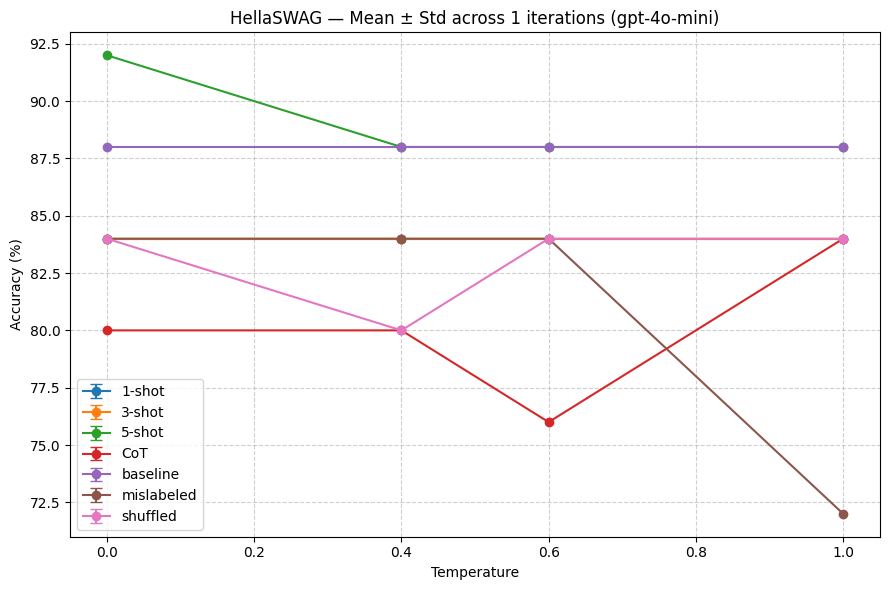

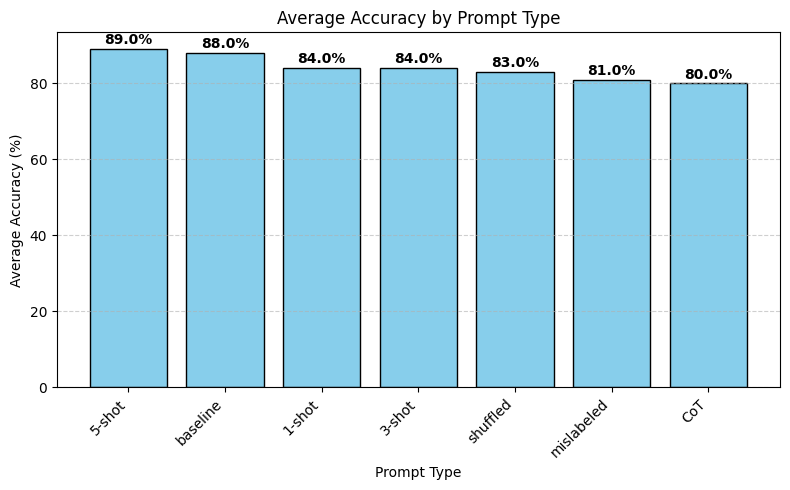

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Detailed results saved and downloaded: llm_experiment_results.csv


,Prompt,Temperature,mean_acc,std_acc
0,1-shot,0.0,84.0,NaN
1,1-shot,0.4,84.0,NaN
2,1-shot,0.6,84.0,NaN
3,1-shot,1.0,84.0,NaN
4,3-shot,0.0,84.0,NaN
5,3-shot,0.4,84.0,NaN
6,3-shot,0.6,84.0,NaN
7,3-shot,1.0,84.0,NaN
8,5-shot,0.0,92.0,NaN
9,5-shot,0.4,88.0,NaN


,prompt_type,temperature,iteration,question_index,prompt_text,model_output,gold_output,predicted_output,is_correct
0,baseline,0.0,1,0,You are a reasoning assistant. Choose the most...,Answer: option 0,0,0,True
1,baseline,0.0,1,1,You are a reasoning assistant. Choose the most...,Answer: option 0,0,0,True
2,baseline,0.0,1,2,You are a reasoning assistant. Choose the most...,Answer: option 3,3,3,True
3,baseline,0.0,1,3,You are a reasoning assistant. Choose the most...,Answer: option 3,3,3,True
4,baseline,0.0,1,4,You are a reasoning assistant. Choose the most...,Answer: option 2,2,2,True


In [22]:
import re, os, pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

def parse_option(raw_text):
    text = raw_text.lower()
    for i in range(4):
        if f"option {i}" in text:
            return i
    m = re.search(r"\b([0-3])\b", text)
    if m:
        return int(m.group(1))
    return None


def parse_option_CoT(raw_text):
    text = raw_text.strip()
    matches = re.findall(
        r"answer\s*[:\-]?\s*(?:option\s*)?([0-3])\b",
        text,
        flags=re.IGNORECASE
    )
    if matches:
        return int(matches[-1])
    return None


# ------------------------------------------------------------
# 5️⃣ Single run (per temperature, per iteration)
# ------------------------------------------------------------
def run_experiments(model="gpt-4o-mini", temperature=0.0, iteration=1):
    summary = []
    answers = []  # store detailed outputs

    for name, template in prompts.items():
        print(f"🧪 Running {name}...")
        correct = 0

        for idx, row in df.iterrows():
            prompt_text = template.format(
                context=row["context"],
                o0=row["option0"],
                o1=row["option1"],
                o2=row["option2"],
                o3=row["option3"]
            )
            try:
                resp = client.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": prompt_text}],
                    temperature=temperature
                )
                raw = resp.choices[0].message.content.strip()
            except Exception as e:
                raw = f"__ERROR__ {e}"

            pred = parse_option(raw)
            if name == "CoT":
                pred = parse_option_CoT(raw)

            gold = int(row["label"])
            is_correct = (pred == gold)

            print(f"\n🔹 {name} | Temp={temperature} | Q#{idx}")

            answers.append({
                "prompt_type": name,
                "temperature": temperature,
                "iteration": iteration,
                "question_index": idx,
                "prompt_text": prompt_text,
                "model_output": raw,
                "gold_output": gold,
                "predicted_output": pred,
                "is_correct": is_correct
            })

            if is_correct:
                correct += 1

        acc = round(100 * correct / len(df), 2)
        summary.append({"Prompt": name, "Accuracy": acc, "Temperature": temperature, "Iteration": iteration})

    return pd.DataFrame(summary), pd.DataFrame(answers)


# ------------------------------------------------------------
# 6️⃣ Multi-temperature + multi-iteration loop
# ------------------------------------------------------------
def run_temperature_variance(model="gpt-4o-mini", temps=[0.0, 0.4, 0.6, 1.0], n_iters=1):
    all_runs = []
    all_answers = []

    for t in temps:
        for i in range(1, n_iters + 1):
            print(f"\n🔥 Running Temperature={t} | Iteration={i}\n{'='*80}")
            df_run, df_answers = run_experiments(model=model, temperature=t, iteration=i)
            all_runs.append(df_run)
            all_answers.append(df_answers)

    all_data = pd.concat(all_runs, ignore_index=True)
    all_answers_df = pd.concat(all_answers, ignore_index=True)

    # Compute variance and mean
    agg = all_data.groupby(["Prompt", "Temperature"]).agg(
        mean_acc=("Accuracy", "mean"),
        std_acc=("Accuracy", "std")
    ).reset_index()

    # -------------- 📊 PLOT 1: Temperature-wise line chart -----------------
    plt.figure(figsize=(9, 6))
    for name in agg["Prompt"].unique():
        subset = agg[agg["Prompt"] == name]
        plt.errorbar(
            subset["Temperature"],
            subset["mean_acc"],
            yerr=subset["std_acc"],
            marker="o",
            capsize=4,
            label=name
        )
    plt.xlabel("Temperature")
    plt.ylabel("Accuracy (%)")
    plt.title(f"HellaSWAG — Mean ± Std across {n_iters} iterations ({model})")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # -------------- 📊 PLOT 2: Average accuracy per prompt -----------------
    avg_acc = (
        all_data.groupby("Prompt")["Accuracy"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )

    plt.figure(figsize=(8, 5))
    bars = plt.bar(avg_acc["Prompt"], avg_acc["Accuracy"], color="skyblue", edgecolor="black")
    plt.title("Average Accuracy by Prompt Type")
    plt.xlabel("Prompt Type")
    plt.ylabel("Average Accuracy (%)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    # annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}%",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Save and download CSV
    output_path = "llm_experiment_results.csv"
    all_answers_df.to_csv(output_path, index=False)
    files.download(output_path)
    print(f"✅ Detailed results saved and downloaded: {output_path}")

    return all_data, agg, all_answers_df


# ------------------------------------------------------------
# 7️⃣ Run
# ------------------------------------------------------------
results_df, summary_stats, full_logs = run_temperature_variance(
    model="gpt-4o-mini",
        temps=[0.0, 0.4, 0.6, 1.0],
    n_iters=1
)

display(summary_stats)
display(full_logs.head())
